In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from io import StringIO

from ase import Atom
from ase.io import read, write
from ase.visualize import view

from ast import literal_eval

from pymatgen.io.ase import AseAtomsAdaptor
# from pymatgen.analysis.diffraction import xrd
from pymatgen.core.spectrum import Spectrum

# Get m-XRD for current SE materials
### from https://doi.org/10.1038/s41467-019-13214-1

In [2]:
df = pd.read_csv('./data/07_1_Liion_comp_528.csv')
df

,formula_id,index,cond,log10_cond,V1,V2,V3,V4,V5,V6,...,V4492,V4493,V4494,V4495,V4496,V4497,V4498,V4499,V4500,V4501
0,In16Li8S32Sn4,1,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.260000e-65,1.630000e-66,2.090000e-67,2.640000e-68,3.280000e-69,4.020000e-70,4.860000e-71,5.790000e-72,6.800000e-73,7.870000e-74
1,Li1O2Ti1,2,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.660000e-65,2.160000e-66,2.770000e-67,3.500000e-68,4.360000e-69,5.360000e-70,6.500000e-71,7.770000e-72,9.150000e-73,1.060000e-73
2,rocksalt,3,8.300000e-07,-6.080922,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.330000e-290,1.630000e-292,1.960000e-294,2.320000e-296,2.710000e-298,3.130000e-300,3.550000e-302,3.970000e-304,4.380000e-306,4.760000e-308
3,Br4Li2Mg1,4,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.240000e-66,2.860000e-67,3.610000e-68,4.480000e-69,5.480000e-70,6.600000e-71,7.850000e-72,9.190000e-73,1.060000e-73,1.210000e-74
4,Br8Li6Mg1,5,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.560000e-66,1.990000e-67,2.500000e-68,3.090000e-69,3.770000e-70,4.540000e-71,5.390000e-72,6.300000e-73,7.260000e-74,8.240000e-75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,B1Li1O14S4,524,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,9.316586e-03,9.355040e-03,9.338097e-03,9.262350e-03,9.125843e-03,8.928183e-03,8.670616e-03,8.356031e-03,7.988912e-03,7.575204e-03
524,C3F9Li1O9Rb2S3,525,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.465153e-03,1.371650e-03,1.278775e-03,1.187161e-03,1.097405e-03,1.010051e-03,9.255890e-04,8.444470e-04,7.669830e-04,6.934900e-04
525,B7Li3O12,526,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.042122e-02,1.020899e-02,9.913110e-03,9.540772e-03,9.101061e-03,8.604549e-03,8.062828e-03,7.488027e-03,6.892335e-03,6.287572e-03
526,B11Li3O18,527,NaN,NaN,4.620000e-174,9.140000e-173,1.790000e-171,3.460000e-170,6.610000e-169,1.250000e-167,...,4.899211e-03,4.784682e-03,4.653151e-03,4.505461e-03,4.342650e-03,4.165911e-03,3.976570e-03,3.776086e-03,3.566060e-03,3.348245e-03


# m-XRD data processing

In [3]:
r_xrd_list=[]
for i in tqdm(range(len(df))):
    x=df.iloc[i][4:-2]
    xx = [max(x[i*5:(i+1)*5]) for i in range(0,900)]
    norm = Spectrum(range(len(xx)),list(xx))
    norm.normalize('sum',10)
    r_xrd_list.append(list(norm.y))
new_df = df.iloc[:,:4]
new_df['r_xrd'] = r_xrd_list
new_df

  0%|          | 0/528 [00:00<?, ?it/s]

,formula_id,index,cond,log10_cond,r_xrd
0,In16Li8S32Sn4,1,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Li1O2Ti1,2,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,rocksalt,3,8.300000e-07,-6.080922,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Br4Li2Mg1,4,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Br8Li6Mg1,5,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...
523,B1Li1O14S4,524,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
524,C3F9Li1O9Rb2S3,525,NaN,NaN,"[0.0, 0.0, 1.92979e-318, 2.4723075750492e-310,..."
525,B7Li3O12,526,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
526,B11Li3O18,527,NaN,NaN,"[6.051556561682696e-169, 1.3000318180921978e-1..."


In [4]:
new_df.to_csv('./data/07_2_mxrd_from_ref.csv',index=False)

In [5]:
df_ref = pd.read_csv('./data/07_2_mxrd_from_ref.csv')[['formula_id','r_xrd','cond']]
df_ref

,formula_id,r_xrd,cond
0,In16Li8S32Sn4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN
1,Li1O2Ti1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN
2,rocksalt,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",8.300000e-07
3,Br4Li2Mg1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN
4,Br8Li6Mg1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN
...,...,...,...
523,B1Li1O14S4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN
524,C3F9Li1O9Rb2S3,"[0.0, 0.0, 1.92979e-318, 2.4723075750492e-310,...",NaN
525,B7Li3O12,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN
526,B11Li3O18,"[6.051556561682696e-169, 1.3000318180921978e-1...",NaN


In [6]:
modified_rxd = []
for j in range(len(df_ref)):
    xrd = literal_eval(df_ref['r_xrd'][j])
    xrd_peak = []
    for i in range(len(xrd)-1):
        if xrd[i] > xrd[i+1] and xrd[i] > xrd[i-1]:
            xrd_peak.append(xrd[i])
        else:
            xrd_peak.append(0.0)
    xrd_peak.append(0.0)

    y = xrd_peak
    x = range(len(y))
    ssp = Spectrum(x,y)
    ssp.smear(0.2,'gaussian')
    ssp.normalize('sum',10)
    modified_rxd.append(ssp.y)
    
df_ref['modified_xrd'] = modified_rxd
df_ref

,formula_id,r_xrd,cond,modified_xrd
0,In16Li8S32Sn4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Li1O2Ti1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,rocksalt,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",8.300000e-07,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Br4Li2Mg1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Br8Li6Mg1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
523,B1Li1O14S4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
524,C3F9Li1O9Rb2S3,"[0.0, 0.0, 1.92979e-318, 2.4723075750492e-310,...",NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
525,B7Li3O12,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
526,B11Li3O18,"[6.051556561682696e-169, 1.3000318180921978e-1...",NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


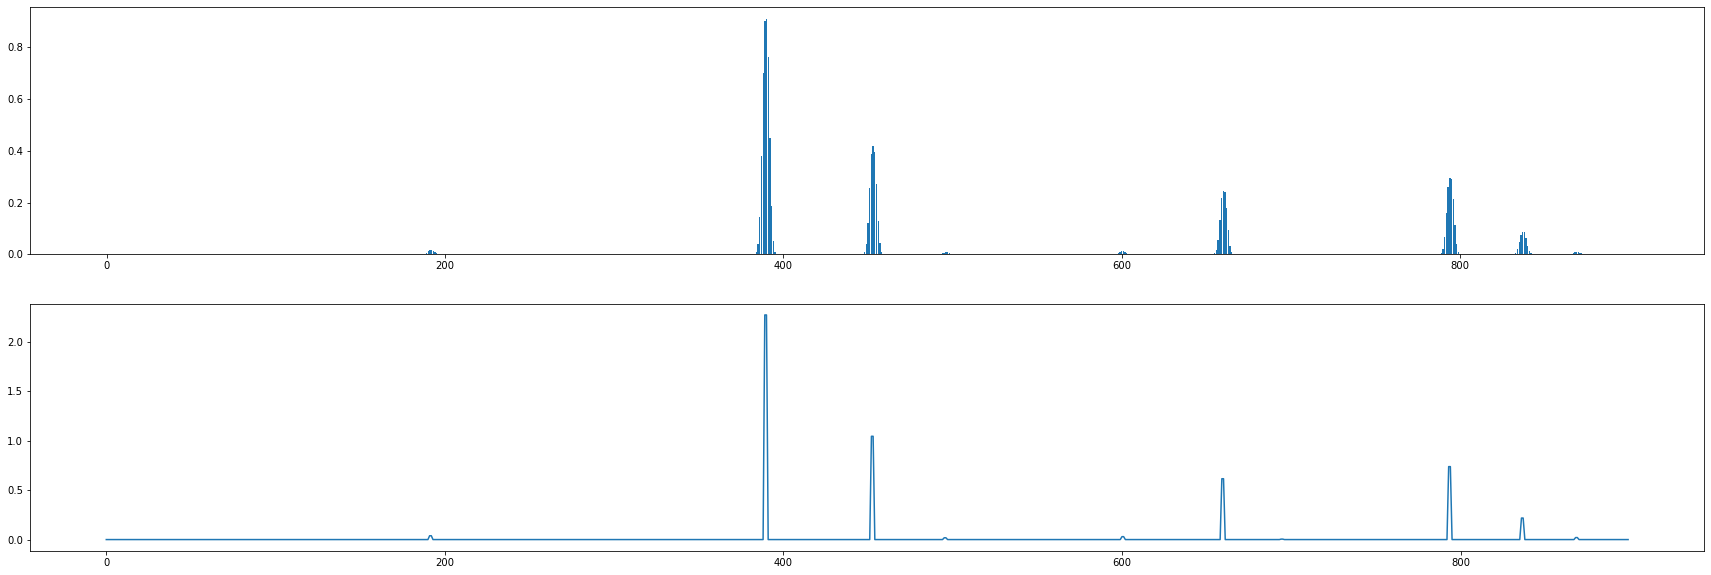

In [7]:
fig, ax = plt.subplots(2,1,figsize=(30,10))
ax[0].bar(x,literal_eval(df_ref['r_xrd'][0]))
ax[1].plot(x,df_ref['modified_xrd'][0])

In [8]:
df_ref.to_csv('./data/07_3_mxrd_from_ref.csv',index=False)